The United States Social Security Administration (SSA) has made available data on the frequency of baby names from 1880 through the present.

With this dataset, I can visualise the proportion of babies given a particular name, determine the relative rank of name, the most popular names in each year, analyze external sources of trends.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\Users\onwoc\anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\onwoc\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


The datast is split by years so I have assembled them into a list and concatenated them to represent one big dataframe

In [2]:
pieces = []

for year in range(1880, 2024):
    path = f"names\yob{year}.txt"
    frame = pd.read_csv(path, names=["name", "sex", "births"])
    
    #Add a colulm for the year
    frame["year"] = year
    pieces.append(frame)
    
    
#Concatenate everything into a single dataframe
names = pd.concat(pieces, ignore_index=True)

In [3]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
2117214,Zyell,M,5,2023
2117215,Zyen,M,5,2023
2117216,Zymirr,M,5,2023
2117217,Zyquan,M,5,2023


In [4]:
 total_births = names.groupby(["year", "sex"])["births"].sum().unstack("sex")

In [5]:
total_births.tail()

sex,F,M
year,,
2019,1676568,1792223
2020,1614196,1723649
2021,1638188,1746499
2022,1636657,1741954
2023,1596022,1701224


<AxesSubplot:title={'center':'Total births by sex and year'}, xlabel='year'>

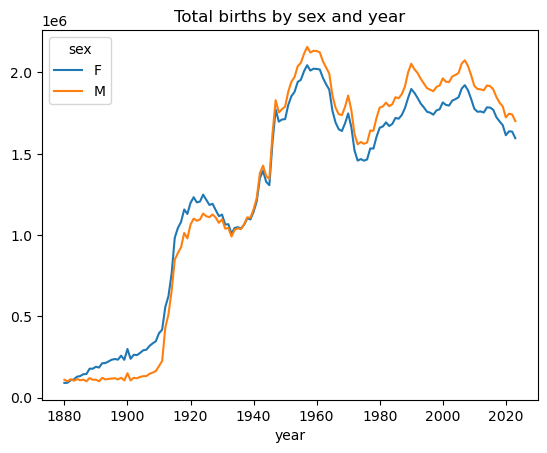

In [6]:
total_births.plot(title="Total births by sex and year")

I want to add a column with the fraction of babies given each name relative to the total number of births. a prop value of 0.04 indicates that 4 out of every 100 babies are given a particular name

In [7]:
names.head()

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [8]:
def add_prop(group):
    group["props"] = group["births"] / group["births"].sum()
    
    return group

names = names.groupby(["year", "sex"], group_keys=False).apply(add_prop)


In [9]:
names.head()

,name,sex,births,year,props
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


I’m going to extract a subset of the data to facilitate further
analysis: the top 1,000 names for each sex/year combination

In [10]:
def get_top1000(group):
    return group.sort_values("births", ascending=False)[:1000]

grouped = names.groupby(["year", "sex"])

top1000 = grouped.apply(get_top1000)

top1000.head()

name sex  births  year     props
year sex                                         
1880 F   0       Mary   F    7065  1880  0.077642
         1       Anna   F    2604  1880  0.028617
         2       Emma   F    2003  1880  0.022012
         3  Elizabeth   F    1939  1880  0.021309
         4     Minnie   F    1746  1880  0.019188

We can drop the group index 

In [11]:
top1000 = top1000.reset_index(drop=True)

In [12]:
top1000.head()

,name,sex,births,year,props
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


given the top 1000 names, we can analyse various naming trends of interest. First we can split the group into boys and girls.

In [13]:
boys = top1000[top1000["sex"] == "M"]
girls = top1000[top1000["sex"] == "F"]

Simple time series, like the number of Johns or Marys for each year, can be plotted
but require some manipulation to be more useful. Im particularly intrested in the trend of pupular athletes names like Michael Jordan and Lebron James

In [14]:
total_births = top1000.groupby(["year","name"])["births"].sum().unstack("name")

In [15]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1880 to 2023
Columns: 7351 entries, Aaden to Zyon
dtypes: float64(7351)
memory usage: 8.1 MB


array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>],
      dtype=object)

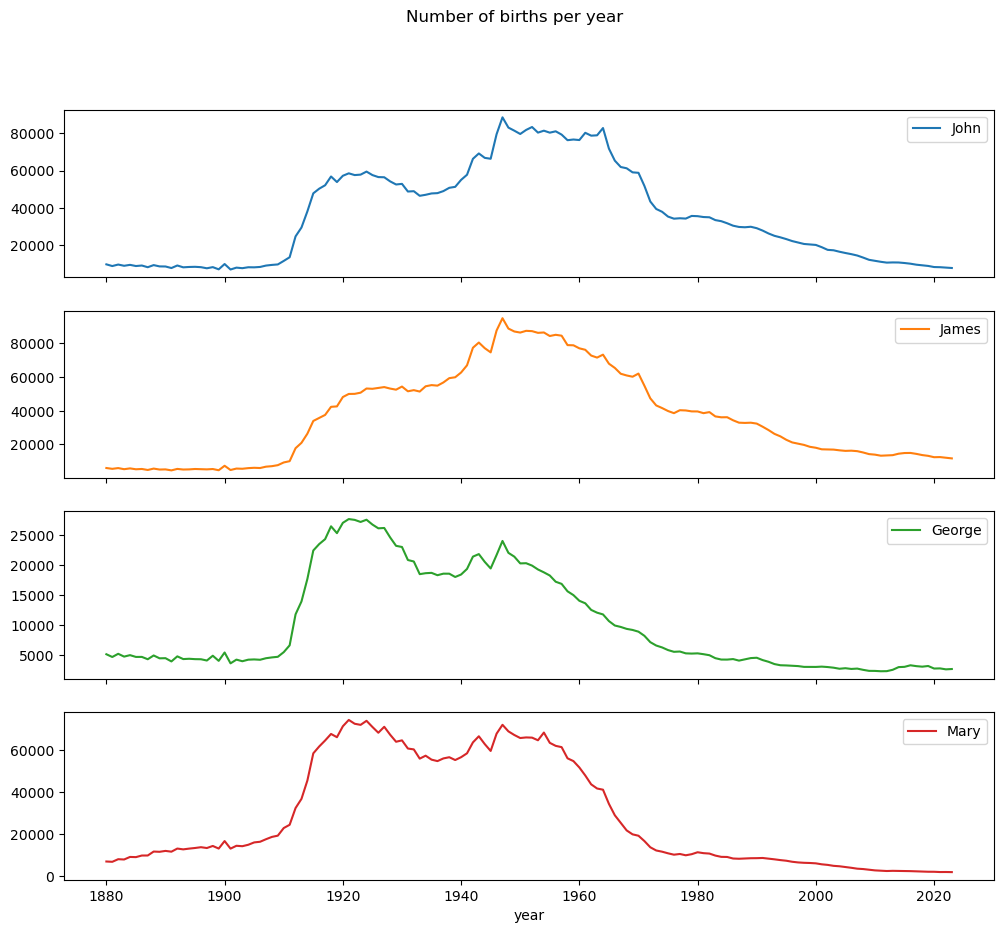

In [16]:
subset = total_births[["John", "James", "George", "Mary"]]

subset.plot(subplots=True, figsize=(12, 10), title="Number of births per year")

One explanation for the decrease in plots is that fewer parents are choosing common
names for their children. This hypothesis can be explored and confirmed in the data.

In [17]:
table = top1000.groupby(["year", "sex"])["props"].sum().unstack("sex")

<AxesSubplot:title={'center':'Sum of table1000.prop by year and sex'}, xlabel='year'>

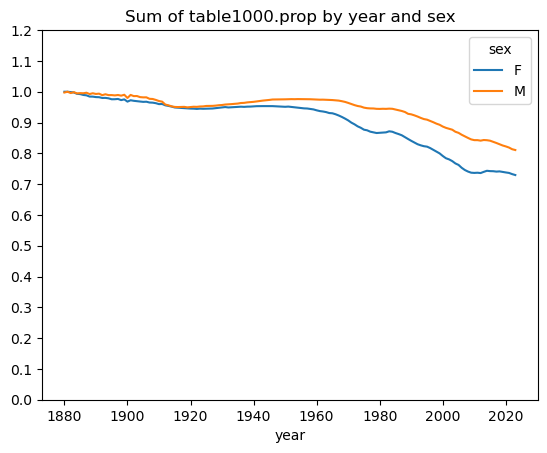

In [18]:
table.plot(title="Sum of table1000.prop by year and sex", yticks=np.linspace(0, 1.2, 13))

there appears to be increasing name diversity (decreasing
total proportion in the top one thousand).

Another interesting metric is the number
of distinct names, taken in order of popularity from highest to lowest, in the top 50%
of births. This number is trickier to compute. Let’s consider just the boy names from
2021

In [19]:
df = boys[boys["year"] == 2021]
df

,name,sex,births,year,props
282876,Liam,M,20391,2021,0.011675
282877,Noah,M,18884,2021,0.010812
282878,Oliver,M,14696,2021,0.008415
282879,Elijah,M,12807,2021,0.007333
282880,James,M,12452,2021,0.007130
...,...,...,...,...,...
283871,Benedict,M,220,2021,0.000126
283872,Kacey,M,220,2021,0.000126
283873,Landry,M,220,2021,0.000126
283874,Maxton,M,220,2021,0.000126


After sorting prop in descending order, I want to know how many of the most
popular names it takes to reach 50%. A vectorized NumPy way is computationally efficient for this task. Taking the cumulative sum, cumsum, of prop and then calling the method searchsorted returns the position in the cumulative sum at which 0.5 would need to be inserted to keep it in sorted order

In [20]:
prop_cumsum = df["props"].sort_values(ascending=False).cumsum()

In [21]:
prop_cumsum[:10]

282876    0.011675
282877    0.022488
282878    0.030902
282879    0.038235
282880    0.045365
282881    0.052327
282882    0.059125
282883    0.065754
282884    0.072260
282885    0.077750
Name: props, dtype: float64

In [22]:
prop_cumsum.searchsorted(0.5)

166

Since arrays are zero-indexed, adding 1 to this result gives you a result of 167. By
contrast, in 1950 this number was much smaller

In [23]:
df = boys[boys["year"] == 1950]
df

,name,sex,births,year,props
140876,James,M,86225,1950,0.048162
140877,Robert,M,83545,1950,0.046665
140878,John,M,79415,1950,0.044358
140879,Michael,M,65137,1950,0.036383
140880,David,M,60728,1950,0.033920
...,...,...,...,...,...
141871,Lenny,M,49,1950,0.000027
141872,Leander,M,49,1950,0.000027
141873,Lawson,M,49,1950,0.000027
141874,Jerrell,M,49,1950,0.000027


In [24]:
in1950 = df["props"].sort_values(ascending=False).cumsum()

In [25]:
in1950.searchsorted(0.5) + 1

23

I can now apply this operation to each year/sex combination, groupby those fields, and apply a function returning the count for each group

In [26]:
def get_quantile_count(group, q=0.5):
    group = group["props"].sort_values(ascending=False)
    return group.cumsum().searchsorted(q) + 1


In [27]:
diversity = top1000.groupby(["year", "sex"]).apply(get_quantile_count).unstack("sex")

In [28]:
diversity.head()

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


<AxesSubplot:title={'center':'Number of popular names in top 50%'}, xlabel='year'>

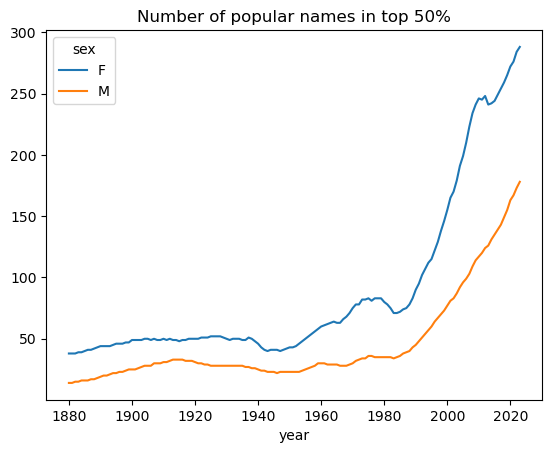

In [29]:
diversity.plot(title="Number of popular names in top 50%")

Girl names have always been more diverse than boy names, and they have only become more so over time.

I want to find out the distribution of boys names that start with vowels over the period

In [30]:
def get_first_letter(x):
    return x[0]

first_letters = names["name"].map(get_first_letter)

In [31]:
first_letters.name = "first_letter"

In [32]:
table = names.pivot_table("births", index=first_letters, columns=["sex", "year"], aggfunc=sum)

In [33]:
#select 3 representative years 
subtable = table.reindex(columns=[1910, 1985, 2022], level="year")

In [34]:
subtable.head()

sex                 F                            M                    
year             1910      1985      2022     1910      1985      2022
first_letter                                                          
A             34095.0  242556.0  269046.0  12706.0  149177.0  181918.0
B             17125.0   64030.0   47942.0   4325.0  120335.0   82710.0
C             18292.0  149742.0   91818.0  15206.0  153095.0  122096.0
D             14533.0   63984.0   41701.0   5251.0  158918.0   84530.0
E             45998.0   80676.0  154971.0  13308.0   56046.0  110513.0

In [35]:
subtable.sum()

sex  year
F    1910     396503.0
     1985    1720774.0
     2022    1636657.0
M    1910     194208.0
     1985    1848201.0
     2022    1741954.0
dtype: float64

normalize the table by total births to compute a new table containing the
proportion of total births for each sex ending in each letter

In [36]:
letter_prop = subtable / subtable.sum()

In [37]:
letter_prop

sex                  F                             M                    
year              1910      1985      2022      1910      1985      2022
first_letter                                                            
A             0.085989  0.140957  0.164388  0.065425  0.080715  0.104433
B             0.043190  0.037210  0.029293  0.022270  0.065109  0.047481
C             0.046133  0.087020  0.056101  0.078297  0.082835  0.070091
D             0.036653  0.037183  0.025479  0.027038  0.085985  0.048526
E             0.116009  0.046884  0.094688  0.068524  0.030325  0.063442
F             0.036895  0.005194  0.010455  0.046703  0.008482  0.011888
G             0.040993  0.008532  0.025506  0.044494  0.021888  0.029714
H             0.048897  0.024375  0.033814  0.065971  0.007096  0.028858
I             0.026285  0.003497  0.028297  0.008105  0.005681  0.018676
J             0.040229  0.110945  0.044032  0.179488  0.195852  0.113001
K             0.012807  0.092927  0.053104  0.006977  0.038101  0.054732
L             0.084711  0.069228  0.072495  0.056506  0.020258  0.076380
M             0.183618  0.090855  0.090272  0.038587  0.093304  0.074427
N             0.019611  0.031172  0.036520  0.011580  0.026347  0.032426
O             0.014361  0.001362  0.018771  0.014078  0.003387  0.023406
P             0.017682  0.009859  0.022464  0.024216  0.022958  0.013347
Q             0.000346  0.000436  0.002468  0.000221  0.001297  0.001663
R             0.054794  0.038658  0.045611  0.081171  0.072863  0.047427
S             0.029097  0.093611  0.073246  0.029726  0.052599  0.042482
T             0.014093  0.046107  0.014456  0.028341  0.049879  0.035298
U             0.000401  0.000156  0.000417  0.000438  0.000327  0.001530
V             0.033152  0.015778  0.021346  0.009263  0.005149  0.006446
W             0.010641  0.004098  0.009935  0.092169  0.020726  0.029026
X                  NaN  0.000170  0.003050       NaN  0.000366  0.004095
Y             0.000744  0.003065  0.005612  0.000103  0.000649  0.005250
Z             0.002668  0.000719  0.018182  0.000309  0.007822  0.015954

With the letter proportions now in hand, we can make bar plots for each sex, broken down by year

<AxesSubplot:title={'center':'Female'}, xlabel='first_letter'>

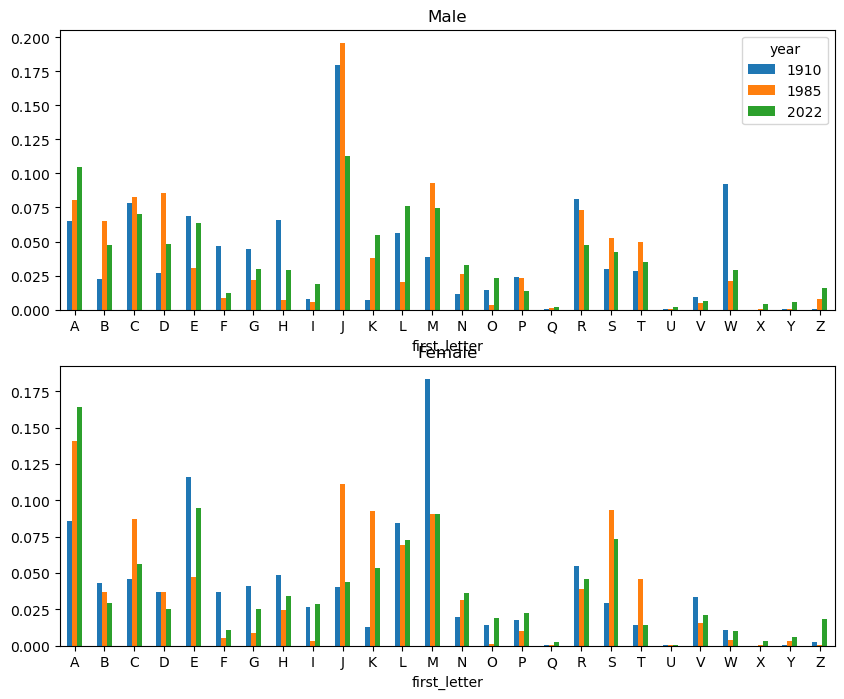

In [38]:
fix, axes = plt.subplots(2, 1, figsize=(10,8))
letter_prop["M"].plot(kind="bar", rot=0, ax=axes[0], title="Male")
letter_prop["F"].plot(kind="bar", rot=0, ax=axes[1], title="Female", legend=False)

Going back to the full table created before, I again normalize by year and
sex and select a subset of letters for the boy names, finally transposing to make each column a time series

In [39]:
letter_prop = table / table.sum()

In [40]:
dny_ts = letter_prop.loc[["J", "M", "A"], "M"].T

In [41]:
dny_ts.head()

first_letter,J,M,A
year,,,
1880,0.201575,0.028654,0.067029
1881,0.201618,0.026634,0.068020
1882,0.197201,0.027981,0.068513
1883,0.195231,0.028292,0.068808
1884,0.193758,0.027883,0.066182


<AxesSubplot:xlabel='year'>

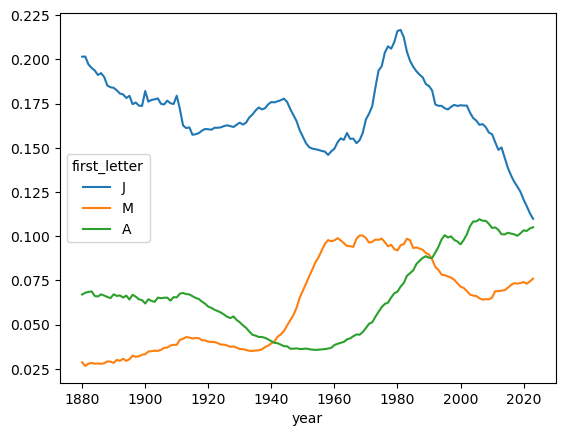

In [42]:
dny_ts.plot()

Another fun trend is looking at names that were more popular with one gender
earlier in the sample but have become preferred as a name for the other gender
over time. One example is the name Lesley or Leslie. Going back to the top1000
DataFrame, I compute a list of names occurring in the dataset starting with "Lesl"

In [43]:
all_names = pd.Series(top1000["name"].unique())

lesley_like = all_names[all_names.str.contains("Lesl")]

lesley_like

632     Leslie
2293    Lesley
4263    Leslee
4730     Lesli
6102     Lesly
dtype: object

From there, we can filter down to just those names and sum births grouped by name
to see the relative frequencies

In [44]:
filtered = top1000[top1000["name"].isin(lesley_like)]

filtered.groupby("name")["births"].sum()

name
Leslee      1083
Lesley     35038
Lesli        929
Leslie    380617
Lesly      11434
Name: births, dtype: int64

In [45]:
#let’s aggregate by sex and year, and normalize within year
table = filtered.pivot_table("births", index="year", columns="sex", aggfunc="sum")

In [46]:
table = table.div(table.sum(axis="columns"), axis="index")

In [47]:
table.tail()

sex,F,M
year,,
2019,1.0,NaN
2020,1.0,NaN
2021,1.0,NaN
2022,1.0,NaN
2023,1.0,NaN


Lastly, it’s now possible to make a plot of the breakdown by sex over time

<AxesSubplot:xlabel='year'>

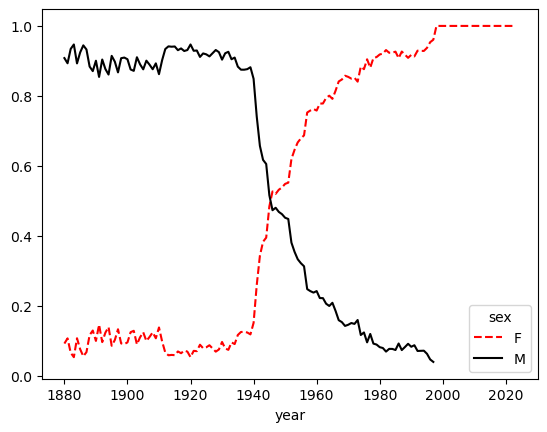

In [48]:
table.plot(style={"M": "k-", "F": "r--"})